# Test on Retrieving Models

In [2]:
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
# need to 'pip install vega' before using renderer
#alt.renderers.enable("notebook")
# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing,metrics
from sklearn.metrics import accuracy_score,f1_score,recall_score,roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.utils import shuffle
import scipy
import os
from joblib import dump, load
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as prfs
# test for Selecting The Best Number Of Components For TSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from varname import varname
%matplotlib inline
#fix random seed
np.random.seed(1)

In [8]:
TRAINING_FILE = "../keyword.csv"
TEST_FILE = "../key_word_test.csv"
df_train = pd.read_csv(TRAINING_FILE)
df_test = pd.read_csv(TEST_FILE)
print(df_train.isnull().sum())
df_train.head(5)

Unnamed: 0         0
article_number     0
article_words      0
topic              0
IR_binary          0
key_word_10       62
key_word_20       18
key_word_50        0
key_word_100       0
dtype: int64


,Unnamed: 0,article_number,article_words,topic,IR_binary,key_word_10,key_word_20,key_word_50,key_word_100
0,0,1,"open,absent,cent,cent,cent,stock,inflow,rate,k...",FOREX MARKETS,False,"stock,rate,defend,bank,bank,bank,bank,bank,dol...","cent,cent,cent,stock,rate,end,won,won,won,won,...","open,cent,cent,cent,stock,rate,end,won,won,won...","open,cent,cent,cent,stock,rate,end,won,won,won..."
1,1,2,"morn,stead,end,end,day,day,day,patch,patch,pat...",MONEY MARKETS,False,"day,day,day,bank,year,dollar,dollar,deal,deal,...","end,end,day,day,day,point,time,bank,year,dolla...","end,end,day,day,day,point,time,bank,early,year...","end,end,day,day,day,index,point,time,busi,bank..."
2,2,3,"socc,socc,world,world,recent,law,fifa,fifa,fif...",SPORTS,False,"world,world,stat,stat,stat,stat,year,releas,re...","world,world,stat,stat,stat,stat,govern,time,ye...","socc,socc,world,world,stat,stat,stat,stat,gove...","socc,socc,world,world,recent,law,stat,stat,sta..."
3,3,4,"open,forint,forint,forint,forint,cent,cent,ste...",FOREX MARKETS,False,"play,bank,bank,mark,mark,percent,percent,perce...","cent,cent,end,play,unit,bank,bank,mark,mark,pe...","open,cent,cent,end,play,unit,made,bank,bank,tu...","open,cent,cent,end,play,unit,made,bank,bank,ra..."
4,4,5,"morn,complet,weekend,minut,minut,minut,arrow,d...",IRRELEVANT,True,day,"day,time,season,clos","minut,minut,minut,day,friday,friday,race,time,...","minut,minut,minut,day,friday,friday,race,time,..."


In [9]:
# Separate out training sets with different size of keywords in the test set
df_test_10 = pd.DataFrame(df_test,columns=['key_word_10','topic']).rename(columns={'key_word_10':'key_word'})
df_test_10.name = 'df_test_10'
df_test_20 = pd.DataFrame(df_test,columns=['key_word_20','topic']).rename(columns={'key_word_20':'key_word'})
df_test_20.name = 'df_test_20'
df_test_50 = pd.DataFrame(df_test,columns=['key_word_50','topic']).rename(columns={'key_word_50':'key_word'})
df_test_50.name = 'df_test_50'
df_test_100 = pd.DataFrame(df_test,columns=['key_word_100','topic']).rename(columns={'key_word_100':'key_word'})
df_test_100.name = 'df_test_100'
df_test_full = pd.DataFrame(df_test,columns=['article_words','topic']).rename(columns={'article_words':'key_word'})
df_test_full.name = 'df_test_full'
df_test_all = [df_test_10,df_test_20,df_test_50,df_test_100,df_test_full]

In [6]:
# def get_df_name(df):
#     return ([x for x in globals() if globals()[x] is df][0])

def get_scores(en_train_y,pred_y,model_name,topic=None):
    f1 = f1_score(en_train_y,pred_y,average='macro')
    accuracy = accuracy_score(en_train_y,pred_y)
    recall = recall_score(en_train_y,pred_y,average='macro')
    if(topic==None):
        print("F1 score for ",model_name," model is ",f1)
        print("Accuracy score for ",model_name," model is ",accuracy)
        print("Recall score for ",model_name," model is ",recall,"\n")
    else:
        return ([topic,{'accuracy':accuracy,'f1':f1,'recall':recall}])
def save_variable(variable,filename):
    file_name = "chosen_models/"+filename+".joblib"
    if not os.path.exists(file_name):
    # Export the model (TFIDF+logistic regressor)
        with open(file_name, "wb") as file:
            dump(variable, file, compress=True)
    else:
        print("Warn: this model already exits...")
        
def retrieve_variable(filename):
    file_name = "chosen_models/"+filename+".joblib"
    return(load(file_name))

def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    #le.fit(train_y)
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def scores_for_topics(df,topics,model,le):
    scores = []
    for topic in topics:
        topic_scores(df,topic,model,le,scores)
    scores.sort(reverse=True,key=lambda x:x[1]['accuracy'])
    for item in scores:
        print(item)

def topic_scores(df,topic,model,le,scores):
    filtered_df = df[df.topic==topic]
    test_x = filtered_df.key_word.apply(lambda x: x.replace('_', ''))
    test_y = filtered_df.topic
    en_test_y = le.transform(test_y)
    prediction = model.predict(test_x)
    scores.append(get_scores(en_test_y,prediction,type(model).__name__,topic))
    
def grid_search(vectorizer,model,train_x,train_y,topics):
    kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
    estimators = [
                ("vectorizer",vectorizer),
                ("model",model)
                  ]
    pipe = Pipeline(estimators)

    param_grid = {
                "vectorizer__min_df":[i for i in range(1,6)],
                "model__alpha":[0.001,0.01,0.1,1],
                "model__class_prior":[None,[1/len(topics) for i in range(len(topics))]],
                "model__fit_prior":[True,False]
                 }
    grid_search = GridSearchCV(pipe, param_grid, cv=kfold, n_jobs=-1)
    grid_result=grid_search.fit(train_x, train_y)
    return (grid_result.best_estimator_,grid_result.best_score_)
    
def get_model(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)
    
def test_model(df_test,model,le,encode_mapping):
    test_x = df_test.key_word
    test_y = df_test.topic
    topics = list(set(df_test['topic']))
    en_test_y = le.transform(test_y)
    y_pred = model.predict(test_x)
    get_scores(en_test_y,y_pred,type(model).__name__)
    print(encode_mapping)
    print(f"Classification Report:\n{classification_report(en_test_y, y_pred)}")
    print("The scores for each topic is:")
    scores_for_topics(df_test,topics,model,le)
    conf_matrix = confusion_matrix(en_test_y, y_pred)
    print(conf_matrix)
    fig1 = plt.figure(figsize=(13,6))
    sns.heatmap(conf_matrix,
    #             square=True,
                annot=True, # show numbers in each cell
                fmt='d', # set number format to integer in each cell
                yticklabels=le.classes_,
                xticklabels=model.classes_,
                cmap="Blues",
    #             linecolor="k",
                linewidths=.1,
               )
    plt.title(
              f"Confusion Matrix on Test Set | " 
              f"Classifier: {'+'.join([step for step in model.named_steps.keys()])}", 
              fontsize=14)
    plt.xlabel("Actual: False positives for y != x", fontsize=12)
    plt.ylabel("Prediction: False negatives for x != y", fontsize=12)
    plt.show()

# SMOTE with CountVectorizer
def get_model_2(df_train):
    # get train_x and train_y
    new_df = df_train
    new_df = new_df.dropna()
    train_x = new_df.key_word.apply(lambda x: x.replace('_', ''))
    train_y = new_df.topic
    le = preprocessing.LabelEncoder()
    le.fit(train_y)
    encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))
    en_train_y = le.transform(train_y)
    topics = list(set(new_df['topic']))
    # Using SMOTE to solve imbalance
    smote = SMOTE(random_state=1)
    vectorizer = CountVectorizer()
    vectorizer.fit(train_x)
    train_vectors = vectorizer.transform(train_x)
    smo_x,smo_y = smote.fit_sample(train_vectors,en_train_y)
    new_train_x = vectorizer.inverse_transform(smo_x)
    new_train_x = pd.Series([','.join(item) for item in new_train_x])
    # Start grid search
    count_clf_NB,count_clf_accuracy = grid_search(CountVectorizer(),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    tfidf_clf_NB,tfidf_clf_accuracy = grid_search(TfidfVectorizer(norm=None),MultinomialNB(),\
                                                  new_train_x,smo_y,topics)
    if(count_clf_accuracy>=tfidf_clf_accuracy):
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is count_clf_NB')
        print(f'The accuracy is {count_clf_accuracy}')
        return (count_clf_NB,le,encode_mapping)
    else:
        print(f'*************************************************************')
        print(f'Now the training set is {df_train.name}, and the model chosen is tfidf_clf_NB')
        print(f'The accuracy is {tfidf_clf_accuracy}')
        return (tfidf_clf_NB,le,encode_mapping)

In [7]:
clf_NB_1 = retrieve_variable('clf_NB_1')
clf_NB_2 = retrieve_variable('clf_NB_2')
clf_NB_3 = retrieve_variable('clf_NB_3')
rel_clf_tfidf_NB = retrieve_variable('rel_clf_tfidf_NB')
svm_proba = retrieve_variable('svm_proba')
tfidf_logi_pipe = retrieve_variable('tfidf_logi_pipe')

## Test on MultinomialNB

In [10]:
new_df = df_train
train_y = new_df.topic
le = preprocessing.LabelEncoder()
le.fit(train_y)
encode_mapping = dict(zip(le.classes_, range(len(le.classes_))))

### Test on rel_clf_tfidf_NB

### Test on clf_NB_1

F1 score for  Pipeline  model is  0.41275263275911606
Accuracy score for  Pipeline  model is  0.36
Recall score for  Pipeline  model is  0.7108860533059618 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.57      0.53      0.55        15
           2       0.24      0.92      0.38        13
           3       0.04      1.00      0.08         2
           4       0.31      0.85      0.45        48
           5       0.56      0.71      0.63        14
           6       0.83      0.02      0.04       266
           7       0.40      0.49      0.44        69
           8       0.20      0.33      0.25         3
           9       0.10      1.00 

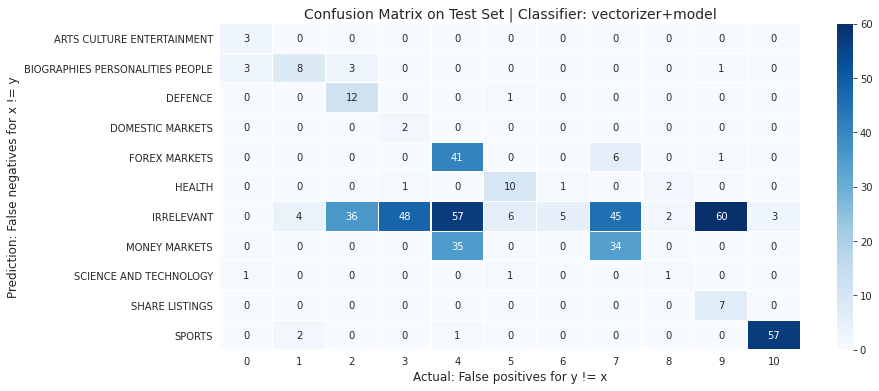

In [11]:
test_model(df_test_50,clf_NB_1,le,encode_mapping)

### Test on clf_NB_2

F1 score for  Pipeline  model is  0.40439636005509955
Accuracy score for  Pipeline  model is  0.414
Recall score for  Pipeline  model is  0.6327242646750656 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.56      0.33      0.42        15
           2       0.32      0.85      0.47        13
           3       0.05      1.00      0.10         2
           4       0.39      0.31      0.35        48
           5       0.52      0.86      0.65        14
           6       0.88      0.14      0.24       266
           7       0.36      0.86      0.50        69
           8       0.33      0.33      0.33         3
           9       0.09      1.00

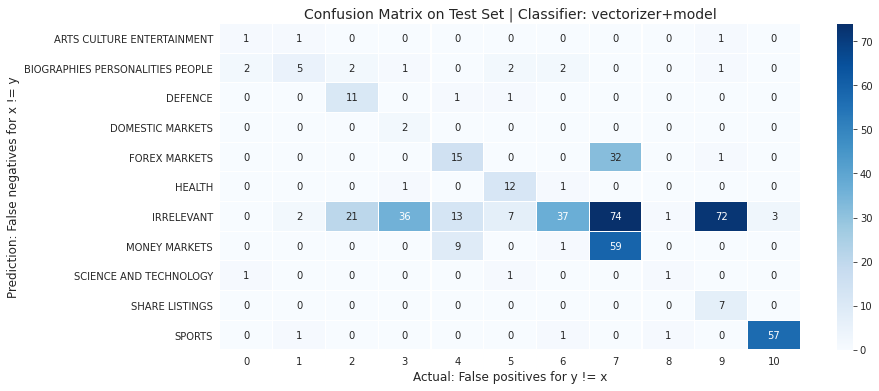

In [12]:
test_model(df_test_100,clf_NB_2,le,encode_mapping)

### Test on clf_NB_3

F1 score for  Pipeline  model is  0.49485225164114177
Accuracy score for  Pipeline  model is  0.528
Recall score for  Pipeline  model is  0.7576468725782225 

{'ARTS CULTURE ENTERTAINMENT': 0, 'BIOGRAPHIES PERSONALITIES PEOPLE': 1, 'DEFENCE': 2, 'DOMESTIC MARKETS': 3, 'FOREX MARKETS': 4, 'HEALTH': 5, 'IRRELEVANT': 6, 'MONEY MARKETS': 7, 'SCIENCE AND TECHNOLOGY': 8, 'SHARE LISTINGS': 9, 'SPORTS': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.30      1.00      0.46         3
           1       0.52      0.73      0.61        15
           2       0.31      0.85      0.46        13
           3       0.06      1.00      0.11         2
           4       0.37      0.79      0.51        48
           5       0.61      0.79      0.69        14
           6       0.97      0.31      0.47       266
           7       0.44      0.57      0.49        69
           8       0.50      0.33      0.40         3
           9       0.16      1.00

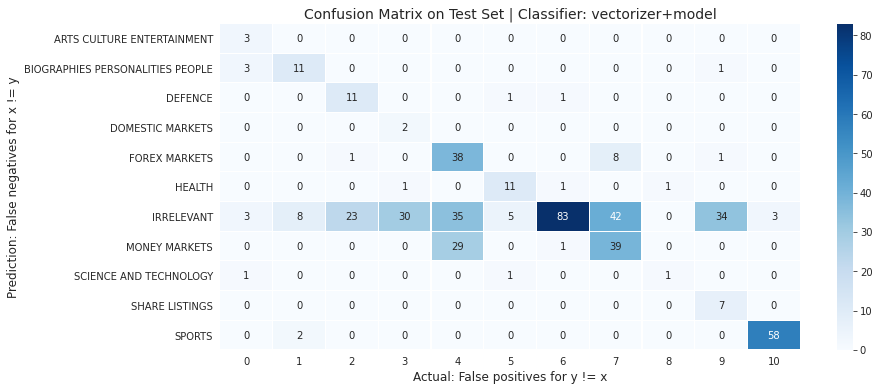

In [13]:
test_model(df_test_50,clf_NB_3,le,encode_mapping)

## Test on 